In [ ]:
import pickle
from google.colab import drive

import pandas as pd
import numpy as np

import requests
from bs4 import BeautifulSoup
import os

In [ ]:
# Google dirve에 연결

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# PATH
PATH_train='/content/drive/MyDrive/montage_project/train/'
PATH_train_montage = '/content/drive/MyDrive/montage_project/train/montage/'
PATH_train_json = '/content/drive/MyDrive/montage_project/train/H/'

PATH_mp='/content/drive/MyDrive/montage_project/'

In [ ]:
PATH_test='/content/drive/MyDrive/montage_project/test/'
PATH_test_montage = '/content/drive/MyDrive/montage_project/test/montage/'
PATH_test_json = '/content/drive/MyDrive/montage_project/test/H/'


---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# 불러오기

In [ ]:
import gzip
# 6. 전처리 + 헤어스타일 라벨 5개 + 증강(23832)+ 콜백

## train 불러오기!
with gzip.open(PATH_train+'dic_train_label_type7.pickle','rb') as f:
  dic_train_label = pickle.load(f)

print(len(dic_train_label),dic_train_label.keys())

4 dict_keys(['train_img_ar', 'train_hairstyle_label', 'val_img_ar', 'val_hairstyle_label'])


In [ ]:
dic_train_label['train_img_ar'][0].shape

(224, 224, 3)

In [ ]:
len(dic_train_label['train_img_ar']),len(dic_train_label['train_hairstyle_label'])

(21757, 21757)

In [ ]:
len(dic_train_label['val_img_ar']),len(dic_train_label['val_hairstyle_label'])

(1000, 1000)

In [ ]:
import numpy
unique, counts = numpy.unique(dic_train_label['train_hairstyle_label'], return_counts=True)
dict(zip(unique, counts))

{0: 4508, 1: 4128, 2: 4388, 3: 4467, 4: 4266}

In [ ]:
import numpy
unique, counts = numpy.unique(dic_train_label['val_hairstyle_label'], return_counts=True)
dict(zip(unique, counts))

{0: 276, 1: 28, 2: 123, 3: 568, 4: 5}

In [ ]:
import gzip

## test 불러오기!
with gzip.open(PATH_test+'dic_test_label_type7.pickle','rb') as f:
  dic_test_label = pickle.load(f)

print(len(dic_test_label),dic_test_label.keys())

2 dict_keys(['test_img_ar', 'test_hairstyle_label'])


In [ ]:
dic_test_label['test_img_ar'][0].shape

(224, 224, 3)

In [ ]:
len(dic_test_label['test_img_ar']),len(dic_test_label['test_hairstyle_label'])

(1010, 1010)

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers, models #Tensorflow에 있는 Keras 함수들 호출하기

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import datasets, layers, models

from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D
from tensorflow.keras import Input
from tensorflow.keras.layers import Dropout, BatchNormalization

In [ ]:
type(dic_train_label['train_img_ar']),type(dic_test_label['test_img_ar'])

(numpy.ndarray, numpy.ndarray)

In [ ]:
len(dic_train_label['train_img_ar']),len(dic_test_label['test_img_ar'])

(21757, 1010)

In [ ]:
dic_train_label['train_img_ar'][0].shape,dic_test_label['test_img_ar'][0].shape

((224, 224, 3), (224, 224, 3))

In [ ]:
type(dic_train_label['train_hairstyle_label']),type(dic_test_label['test_hairstyle_label'])

(numpy.ndarray, numpy.ndarray)

In [ ]:
len(dic_train_label['train_hairstyle_label']),len(dic_test_label['test_hairstyle_label'])

(21757, 1010)

In [ ]:
dic_train_label['train_hairstyle_label'][1000],dic_test_label['test_hairstyle_label'][1000]

(2, 1)

In [ ]:
set(dic_train_label['train_hairstyle_label'])

{0, 1, 2, 3, 4}

In [ ]:
train_input = dic_train_label['train_img_ar']
test_input = dic_test_label['test_img_ar']

train_target = dic_train_label['train_hairstyle_label']
test_target =dic_test_label['test_hairstyle_label']

val_input=dic_train_label['val_img_ar']
val_target=dic_train_label['val_hairstyle_label']

In [ ]:
train_input.shape,train_target.shape,val_input.shape,val_target.shape

((21757, 224, 224, 3), (21757,), (1000, 224, 224, 3), (1000,))

In [ ]:
test_input.shape,test_target.shape

((1010, 224, 224, 3), (1010,))

In [ ]:
set(train_target)

{0, 1, 2, 3, 4}

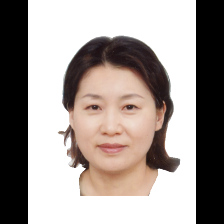

In [ ]:
from google.colab.patches import cv2_imshow

cv2_imshow(train_input[0])



In [ ]:
## 일부 재학습 모델
base_model = ResNet50(include_top=False, input_shape = (224, 224,3), weights = 'imagenet')

for layer in base_model.layers[:-10]: 
    layer.trainable = False			

inputs = tf.keras.Input(shape=(224, 224, 3))

x = base_model(inputs, training=False) # batchnorm 부분 update 방지

x = tf.keras.layers.Flatten(input_shape=base_model.output_shape[1:])(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x= tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

model.compile(optimizer = tf.keras.optimizers.Adam( learning_rate= 0.0001),
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 49,279,365
Trainable params: 30,157,317
Non-tra

In [ ]:
# monitor : ReduceLROnPlateau의 기준이 되는 값을 입력합니다.
# factor : Learning rate를 얼마나 감소시킬 지 정하는 인자값입니다.새로운 learning rate는 기존 learning rate * factor입니다.예를 들어 현재 lr이 0.01이고 factor가 0.8일 때, 콜백함수가 실행된다면 그 다음 lr은 0.008이 됩니다.또다른 예로 현재 lr이 0.3이고 factor가 0.1일 때, 콜백함수가 실행된다면 그 다음 lr은 0.03이 됩니다. 
# patience :  Training이 진행됨에도 더이상 monitor되는 값의 개선이 없을 경우, 최적의 monitor 값을 기준으로 몇 번의 epoch을 진행하고, learning rate를 조절할 지의 값입니다. 
# min_lr	: Learning rate의 하한선을 지정합니다.


# verbose	:0 또는 11일 경우, EarlyStopping이 적용될 때, 화면에 적용되었다고 나타냅니다.0일 경우, 화면에 나타냄 없이 종료합니다.
# mode	: "auto" 또는 "min" 또는 "max"monitor되는 값이 최소가 되어야 하는지, 최대가 되어야 하는지 알려주는 인자입니다.예를 들어, monitor하는 값이 val_acc 즉 정확도일 경우, 값이 클수록 좋기때문에 "max"를 입력하고, val_loss일 경우 작을수록 좋기 때문에 "min"을 입력합니다."auto"는 모델이 알아서 판단합니다.
# min_delta	: 개선된 것으로 간주하기 위한 최소한의 변화량입니다
# cooldown	: Learning rate가 감소한 후, ReduceLROnPlateau 콜백함수를 다시 실행하기 전에 대기 할 Epoch 수입니다. 예시로 이해하는 게 좋을 것 같습니다.


callbacks = [  
        tf.keras.callbacks.EarlyStopping(patience=2),  
        tf.keras.callbacks.ModelCheckpoint(filepath=PATH_train+'model.{epoch:02d}-{loss:.2f}.h5'),  
        tf.keras.callbacks.TensorBoard(log_dir='./logs'),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=1, min_lr=0.001)
    ]  

In [ ]:
# 학습
# 7. 전처리 + 헤어스타일 라벨 5개 + 증강(21757)+ 콜백(p=2,c=에폭,텐서보드,lr=reduce)

model.fit(train_input, train_target, epochs = 30, batch_size= 125, validation_data=(val_input, val_target),callbacks=[callbacks])

Epoch 1/30
175/175 [==============================] - 2017s 12s/step - loss: 1.0189 - accuracy: 0.6250 - val_loss: 0.7020 - val_accuracy: 0.7090 - lr: 1.0000e-04
Epoch 2/30
175/175 [==============================] - 2023s 12s/step - loss: 0.6450 - accuracy: 0.7435 - val_loss: 0.6691 - val_accuracy: 0.7170 - lr: 1.0000e-04
Epoch 3/30
175/175 [==============================] - 2001s 11s/step - loss: 0.5547 - accuracy: 0.7738 - val_loss: 0.6635 - val_accuracy: 0.7020 - lr: 1.0000e-04
Epoch 4/30
175/175 [==============================] - 1998s 11s/step - loss: 0.5042 - accuracy: 0.7977 - val_loss: 0.6229 - val_accuracy: 0.7320 - lr: 1.0000e-04
Epoch 5/30
175/175 [==============================] - 2006s 11s/step - loss: 0.4230 - accuracy: 0.8261 - val_loss: 0.5849 - val_accuracy: 0.7430 - lr: 1.0000e-04
Epoch 6/30
175/175 [==============================] - 2043s 12s/step - loss: 0.3697 - accuracy: 0.8458 - val_loss: 0.5551 - val_accuracy: 0.7540 - lr: 1.0000e-04
Epoch 7/30
175/175 [========

In [ ]:
## fine-tune
base_model.trainable = True

model.compile(optimizer = tf.keras.optimizers.Adam( learning_rate= 0.0001),
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])

model.fit(train_input, train_target, epochs = 30, validation_data=(val_input, val_target), batch_size= 125,callbacks=[callbacks])

Epoch 1/30
175/175 [==============================] - 7135s 41s/step - loss: 1.4243 - accuracy: 0.5602 - val_loss: 0.7713 - val_accuracy: 0.6500 - lr: 1.0000e-04
Epoch 2/30
175/175 [==============================] - 7150s 41s/step - loss: 0.6901 - accuracy: 0.7250 - val_loss: 0.7661 - val_accuracy: 0.6690 - lr: 1.0000e-04
Epoch 3/30
175/175 [==============================] - 7368s 42s/step - loss: 0.5625 - accuracy: 0.7758 - val_loss: 0.7124 - val_accuracy: 0.6950 - lr: 1.0000e-04
Epoch 4/30
175/175 [==============================] - 7252s 41s/step - loss: 0.5009 - accuracy: 0.7984 - val_loss: 0.6613 - val_accuracy: 0.7180 - lr: 1.0000e-04
Epoch 5/30
175/175 [==============================] - 7261s 41s/step - loss: 0.4243 - accuracy: 0.8263 - val_loss: 0.6197 - val_accuracy: 0.7240 - lr: 1.0000e-04
Epoch 6/30
175/175 [==============================] - 7339s 42s/step - loss: 0.3778 - accuracy: 0.8418 - val_loss: 0.5758 - val_accuracy: 0.7640 - lr: 1.0000e-04
Epoch 7/30
 51/175 [=======>

In [ ]:
# 시험
model.evaluate(test_input, test_target)

In [ ]:
y_predict = model.predict(test_input)
print(y_predict) #[[0.67222077]]
print(y_predict[0]) #[0.67222077]
print(y_predict[0][0]) #0.67222077
label = labels[1 if y_predict[0][0] > 0.5 else 0]
confidence = y_predict[0][0] if y_predict[0][0] > 0.5 else 1 - y_predict[0][0]
print(label, confidence) #

In [ ]:
PATH_mp='/content/drive/MyDrive/montage_project/'

model.save(PATH_mp+'model_type7.h5')